In [4]:
%matplotlib inline
# import matplotlib.image as mpimg
# from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from helpers import *
from tf_aerial_images import *
from sklearn import linear_model
from types import SimpleNamespace 

from preprocessing import *
from datetime import datetime
from evaluate import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# remind of confusion matrix
print('Confusion matrix:')
confmat = pd.DataFrame(
    data = [['True Negative (TN)', 'False Negative (FN)'], ['False Positive (FP)', 'True Positive (TP)']],
    index = pd.MultiIndex(
        levels=[['predicted (Z)'], ['0', '1']],
        labels=[[0, 0], [0, 1]]),
    columns = pd.MultiIndex(
        levels=[['actual (Y)'], ['0 (background)', '1 (road)']],
        labels=[[0, 0], [0, 1]]),
)
display(confmat)
print('TN + FN + FP + TP = number of predictions')

Confusion matrix:


actual (Y)                     
                      0 (background)             1 (road)
predicted (Z) 0   True Negative (TN)  False Negative (FN)
              1  False Positive (FP)   True Positive (TP)

TN + FN + FP + TP = number of predictions


## 1. Load data

In [2]:
# Loaded a set of images
n = 100

imgs, gt_imgs = load_images(n)

imgs.shape, gt_imgs.shape

Loading 100 images


((400, 400, 3), (400, 400))

In [ ]:
# # Show first image and its groundtruth image
# cimg = concatenate_images(imgs[1], gt_imgs[1])
# fig1 = plt.figure(figsize=(20, 10))
# plt.imshow(cimg, cmap='Greys_r', vmin=0, vmax=1)

## 2. Transform in in put and output

From each image extract the inputs (patches) and generate a list of features for each one of them.

In [10]:
imgs.shape, X.shape, gt_imgs.shape, Y.shape

((100, 400, 400, 3), (62500, 6), (100, 400, 400), (62500,))

In [9]:
set_ = SimpleNamespace()
set_.X = imgs_to_inputs(imgs)
set_.Y = imgs_to_outputs(gt_imgs)

In [11]:
train, test = split_train_test(set_.X, set_.Y, test_ratio=0.2, seed=1)

train.X.shape, train.Y.shape, test.X.shape, test.Y.shape

((50000, 6), (50000,), (12500, 6), (12500,))

Just check the **output** has been generated correctly.

In [12]:
# Print feature statistics
Y0 = np.where(train.Y==0)[0]
Y1 = np.where(train.Y==1)[0]
print(str(len(Y0)) + ' inputs are classified as background (0)')
print(str(len(Y1)) + ' inputs are classified as road (1)')

37017 inputs are classified as background (0)
12983 inputs are classified as road (1)


## 3. Train and evaluate: naive, logistic and random forest models

### a. Naive
Predict all roads

/home/niccolo/anaconda3/envs/ada/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                precision    recall  f1-score   support

0 (background)       0.00      0.00      0.00     37017
      1 (road)       0.26      1.00      0.41     12983

   avg / total       0.07      0.26      0.11     50000

Confusion matrix, without normalization


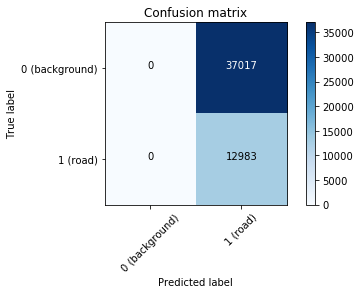

Normalized confusion matrix


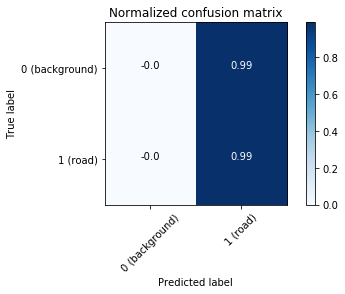

In [18]:
train.Z = np.ones(train.Y.shape)
evaluate_predictions(train.Z, train.Y)

### b. Logistic regression

                precision    recall  f1-score   support

0 (background)       0.83      0.56      0.67     37017
      1 (road)       0.35      0.68      0.46     12983

   avg / total       0.71      0.59      0.61     50000

Confusion matrix, without normalization


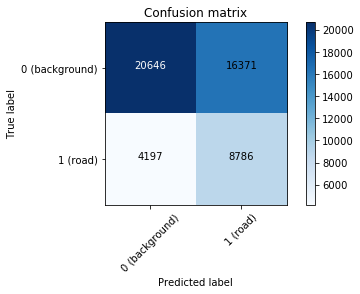

Normalized confusion matrix


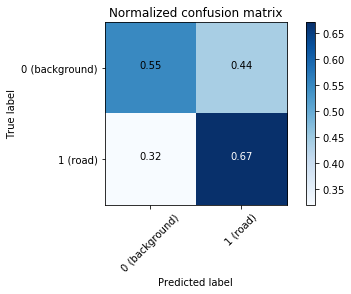

In [16]:
logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced", max_iter=1000)
# train
logreg.fit(train.X, train.Y)
# predict
train.Z = logreg.predict(train.X)
# evaluate
evaluate_predictions(train.Z, train.Y)

### c. Random forest

## 3. Repeat with cross validation 

In [ ]:
def cross_validation(set_):
        # divide the data in 4 folds
        nfolds = 4
        
        F1_scores = {"naive": [], "logistic": [], "random_forest": []}
        kf = KFold(n_splits=nfolds)
        train = SimpleNamespace()
        test = SimpleNamespace()
        for train_indices, test_indices in kf.split(range(set_.X.shape[0])): # split the indices
            # get train and test
            train.X = set_.X[train_indices]
            train.Y = set_.Y[train_indices]
            test.X = set_.X[test_indices]
            test.Y = set_.Y[test_indices]
            
            # fit the models
            
            # compute F1 score of the road labels
            pred = self.model.predict_classes(test.X).flatten()
            true = test.Y.flatten()
            f1 = f1_score(true, pred, pos_label=1, average='binary', sample_weight=None)
            F1_scores.append(f1)
        
        # compute the mean history
        mean_history = {}
        keys = histories[0].keys()
        for key in keys:
            mean_history[key] = np.zeros(len(histories[0][key]))
        for key in keys:
            for h in histories:
                mean_history[key] += np.array(h[key])
            mean_history[key] = (mean_history[key]/len(histories)).tolist()

#### c. Validation

In [ ]:
test.X.shape

In [ ]:
test.Z = logreg.predict(test.X)

In [ ]:
stats(test.Z, test.Y)

In [ ]:
i = 1
image = test.imgs[i]
# lenght of the prediction of one image
len_pred = 625 # 25x25 patches
prediction = test.Z[len_pred*i : len_pred*(i+1)]
display_prediction(image, prediction)

### idea: expand features with the prediction probabilities (not much success...) .
there is something wrong (ignore this part! not worth to spend time in fixing it)

In [ ]:
X_list, Y = initialize_input_output(imgs, gt_imgs)

In [ ]:
X = np.array(flatten([flatten(matr) for matr in X_list]))
output_patches = flatten([flatten(img_crop_matr(img)) for img in gt_imgs])
Y = np.array([int(value_to_class(np.mean(patch))) for patch in output_patches])
X.shape, Y.shape

In [ ]:
models = train_models(train.imgs, train.gt_imgs, n_layers=2)

In [ ]:
Z, Y = test_models(test.imgs, test.gt_imgs, models=models)
Z.shape, Y.shape

In [ ]:
i = 1
image = test.imgs[i]
prediction = Z[i*625:(i+1)*625]
display_prediction(image, prediction)